# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.2 MB/s 
     |████████████████████████████████| 376 kB 48.6 MB/s 
     |████████████████████████████████| 58 kB 1.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=6f86827b89dc12e8095277bf532010f0eb3df6ba424ed034107097dd4940354f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=beb463a700d0525dffcb0750c3841d1c2277dd19979ee8ada28d84c51c66c1b5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 11.19 MiB/s, done.
Resolving deltas: 100% (3/3), done.


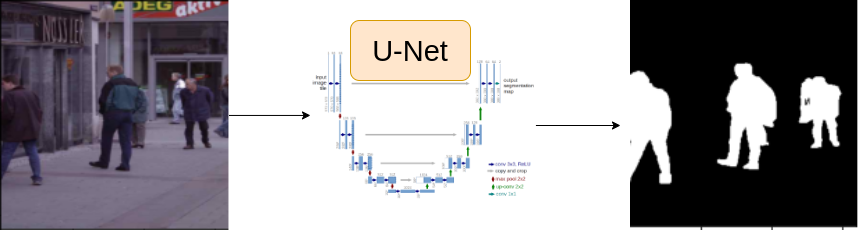

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

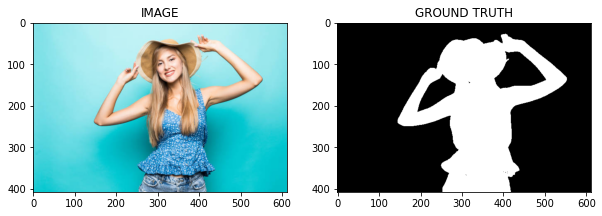

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
# split data
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),  # chance of flip
                    A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, index):
    row = self.df.iloc[index]
    
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # shape = (h, w)
    mask = np.expand_dims(mask, axis=-1)  # convert to shape = (h, w, c) w/ c=1

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # return as dictionary
      image = data.get('image')
      mask = data.get('mask')

    # shift (h, w, c) -> (c, h, w) since we use PyTorch
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # c:axis=2
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # convert to Tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)  # to 0 and 1 (we have 2 classes)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


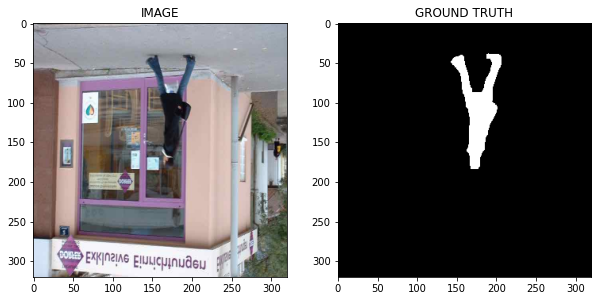

In [16]:
idx = 33

image, mask= trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [29]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
      super(SegmentationModel, self).__init__() # usually do to create model in Pytorch

      self.arc = smp.Unet(
          encoder_name=ENCODER,
          encoder_weights=WEIGHTS,
          in_channels=3,
          classes=1,
          activation=None # output logits will be raw
      )
    
  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None: # must use != else does not run in training: "Boolean value of Tensor with more than one value is ambiguous"
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    
    return logits

In [30]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [31]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(data_loader)

In [32]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [34]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


SAVED-MODEL
Epoch: 1 Train_loss: 0.8747421860694885 Valid_loss: 1.778895914554596


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED-MODEL
Epoch: 2 Train_loss: 0.40136116941769917 Valid_loss: 0.6816306710243225


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED-MODEL
Epoch: 3 Train_loss: 0.35931310852368675 Valid_loss: 0.400445818901062


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED-MODEL
Epoch: 4 Train_loss: 0.2755106051762899 Valid_loss: 0.260945912450552


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch: 5 Train_loss: 0.2311786929766337 Valid_loss: 0.2719925008714199


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch: 6 Train_loss: 0.2994464914004008 Valid_loss: 0.318203117698431


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


SAVED-MODEL
Epoch: 7 Train_loss: 0.2367374360561371 Valid_loss: 0.21148236095905304


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Epoch: 8 Train_loss: 0.2107845996816953 Valid_loss: 0.22737454250454903


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


SAVED-MODEL
Epoch: 9 Train_loss: 0.20297075112660726 Valid_loss: 0.19807185232639313


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


SAVED-MODEL
Epoch: 10 Train_loss: 0.1624058350920677 Valid_loss: 0.17008784413337708


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch: 11 Train_loss: 0.15731302946805953 Valid_loss: 0.17114027217030525


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch: 12 Train_loss: 0.1543873171011607 Valid_loss: 0.28427616134285927


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch: 13 Train_loss: 0.1709700251619021 Valid_loss: 0.23642483726143837


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch: 14 Train_loss: 0.1909016489982605 Valid_loss: 0.26079951226711273


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epoch: 15 Train_loss: 0.16652951836586 Valid_loss: 0.2438519224524498


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch: 16 Train_loss: 0.16397331655025482 Valid_loss: 0.1844202894717455


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch: 17 Train_loss: 0.15015369604031245 Valid_loss: 0.2865719199180603


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch: 18 Train_loss: 0.13440524637699128 Valid_loss: 0.2227432131767273


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch: 19 Train_loss: 0.13448097904523212 Valid_loss: 0.2209300808608532


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


Epoch: 20 Train_loss: 0.1009721909960111 Valid_loss: 0.2645631991326809


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch: 21 Train_loss: 0.09627082546552022 Valid_loss: 0.18366429023444653


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch: 22 Train_loss: 0.0923792873819669 Valid_loss: 0.17269503325223923


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch: 23 Train_loss: 0.09973845680554708 Valid_loss: 0.1879725344479084


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


SAVED-MODEL
Epoch: 24 Train_loss: 0.0887476533651352 Valid_loss: 0.16323642246425152


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

Epoch: 25 Train_loss: 0.08874740302562714 Valid_loss: 0.16899550706148148


# Task 9 : Inference

In [42]:
idx = 5

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze (0))  # (C, H, W) -> (1, C, H, W) where 1 is batch size just to use sigmoid
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

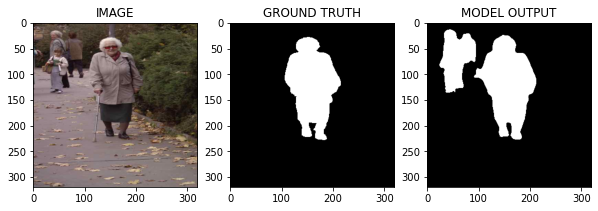

In [43]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # convert back (1, C, H, W) -> (C, H, W)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya